In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
# estimate total, coding and noncoding het
template_dir = "/mnt/seagate10/genotypes/hapgen10k11m"
coding_snps_f = "/mnt/seagate10/MEGAsync/cmm_experiments/e1/hapgen11m.utr5.utr3.exon.snps.txt"

coding_het = 0
noncoding_het = 0
total_het = 0 # total_het = coding_het + noncoding_het

coding_snps = pd.read_csv(coding_snps_f,header=None,names=["SNP"],na_filter=False,squeeze=True)
n_coding = coding_snps.size
n_total = 0 # n_total = n_coding + n_noncoding

for c in range(1,23):
    fname = os.path.join(template_dir, f"chr{c}.maf.frq")
    maf = pd.read_csv(fname,delim_whitespace=True,na_filter=False,usecols=["SNP","MAF"],index_col="SNP",squeeze=True)
    n_total += maf.size
    i_coding = maf.index.isin(coding_snps)
    maf_coding = maf[i_coding]
    total_het += (2*maf*(1-maf)).sum()
    coding_het += (2*maf_coding*(1-maf_coding)).sum()

n_noncoding = n_total - n_coding
noncoding_het = total_het - coding_het

print(f"{n_total} total SNPs")
print(f"{n_coding} coding SNPs")
print(f"{n_noncoding} noncoding SNPs")

print(f"total het     = {total_het}")
print(f"coding het    = {coding_het}")
print(f"noncoding het = {noncoding_het}")

11015833 total SNPs
163636 coding SNPs
10852197 noncoding SNPs
total het     = 2386582.660768025
coding het    = 31810.875463335004
noncoding het = 2354771.7853046902


In [3]:
# create a table with true parameters (p_coding,p_noncoding,s2_coding,s2_noncoding,h2_coding,h2_noncoding,h2,s02),
# their simulated values and corresponding quality parameters.
experiment_dir = "/mnt/seagate10/projects/cmm/experiments/e1" # "/mnt/c/Users/Алексей/Documents/MEGAsync/cmm_experiments/e1/"
out_dir = os.path.join(experiment_dir,"tables")
causals_dir = os.path.join(experiment_dir, "causals")
results_dir = os.path.join(experiment_dir, "results")
run_dirs = [os.path.join(results_dir,d) for d in os.listdir(results_dir) if d.startswith("run_")]
print(f"{len(run_dirs)} run dirs")
n_repeats = 10
# n_coding = 163636      # wc -l /home/alexeas/MEGAsync/cmm_experiments/e1/hapgen11m.utr5.utr3.exon.snps.txt
# n_noncoding = 10852197 # wc -l /home/alexeas/MEGAsync/cmm_experiments/e1/hapgen11m.other.snps.txt
# n_total = 11015833 # = n_coding + n_noncoding
df_ind = 0
ind_symbols = "ABC"
exp_ind_cols = ["run","i_h2","i_p_c","i_p_nc","i_s2","i_repeat"]
true_par_cols = ["p_nc","p_c","s2_nc","s2_c","h2","h2_nc","h2_c","s02","n_nc","n_c"]
sim_par_cols = [f"sim_{c}" for c in true_par_cols]
opt_par_cols = ["success","cost","total_nfev","loc_nfev","loc_nit","glob_nfev","glob_cost"]
quality_par_cols = ["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c", "qual_h2","qual_h2_nc","qual_h2_c","qual_s02"]
merged_df_out = pd.DataFrame(columns=exp_ind_cols+true_par_cols+sim_par_cols+opt_par_cols+quality_par_cols)
# iterate over runs here (take run with the best cost function value)
for run_dir in run_dirs:
    print(f"processing {run_dir}")
    run_num = run_dir.split("_")[-1]
    for i_hsq in range(3):
        for i_coding in range(3):
            for i_noncoding in range(3):
                for i_s2coding in range(3):
                    for i_repeat in range(1,n_repeats+1):
                        exp_ind = [run_num,ind_symbols[i_hsq],ind_symbols[i_coding],ind_symbols[i_noncoding],
                                   ind_symbols[i_s2coding],i_repeat]
                        # process true parameters
                        fname = f"simu.hsq_{i_hsq}.coding_{i_coding}.noncoding_{i_noncoding}.s2coding_{i_s2coding}.{i_repeat}.1.causals"
                        fname = os.path.join(causals_dir,fname)
                        if not os.path.isfile(fname):
                            print(f"{fname} not found")
                            continue
                        # c1 - coding, c2 - noncoding
                        df = pd.read_csv(fname,sep='\t',usecols=["SNP","FRQ","BETA_c1","BETA_c2"],index_col="SNP",
                                         na_filter=False)
                        het = 2*df.FRQ*(1-df.FRQ)
                        i_coding_causals = (df.BETA_c1 != 0)
                        i_noncoding_causals = (df.BETA_c2 != 0)

                        n_nc = i_noncoding_causals.sum()
                        n_c = i_coding_causals.sum()
                        p_coding = n_c/n_coding
                        p_noncoding = n_nc/n_noncoding
                        s2_coding = df.BETA_c1[i_coding_causals].var()
                        s2_noncoding = df.BETA_c2[i_noncoding_causals].var()
                        h2_coding = (df.BETA_c1.pow(2)*het).sum()
                        h2_noncoding = (df.BETA_c2.pow(2)*het).sum()
                        h2 = h2_coding + h2_noncoding
                        s02 = 1
                        true_par = [p_noncoding,p_coding,s2_noncoding,s2_coding,h2,h2_noncoding,h2_coding,s02,n_nc,n_c]

                        # process simultated parameters
                        sim_fname = f"optimize.hsq_{i_hsq}.coding_{i_coding}.noncoding_{i_noncoding}.s2coding_{i_s2coding}.{i_repeat}.npz"
                        sim_fname = os.path.join(run_dir, sim_fname)
                        if not os.path.isfile(sim_fname):
#                             print(f"{sim_fname} not found")
                            continue
                        sim = np.load(sim_fname)
                        # i_noncoding = 0, i_coding = 1
                        sim_p_coding = sim["p_opt"][1]
                        sim_p_noncoding = sim["p_opt"][0]
                        sim_n_nc = n_noncoding*sim_p_noncoding
                        sim_n_c = n_coding*sim_p_coding
                        sim_s2_coding = sim["sb2_opt"][1]
                        sim_s2_noncoding = sim["sb2_opt"][0]
                        sim_h2_coding = sim_p_coding*sim_s2_coding*coding_het
                        sim_h2_noncoding = sim_p_noncoding*sim_s2_noncoding*noncoding_het
                        sim_h2 = sim_h2_coding + sim_h2_noncoding
                        sim_s02 = sim["s02_opt"]
                        sim_par = [sim_p_noncoding,sim_p_coding,sim_s2_noncoding,sim_s2_coding,sim_h2,sim_h2_noncoding,
                                   sim_h2_coding,sim_s02,sim_n_nc,sim_n_c]
                        success = sim["success"]
                        cost = sim["fun"]
                        local_nfev = sim["nfev"]
                        local_niter = sim["nit"]
                        global_nfev = sim["global_nfev"]
                        global_cost = sim["global_fun"]
                        total_nfev = global_nfev + local_nfev
                        opt_par = [success,cost,total_nfev,local_nfev,local_niter,global_nfev,global_cost]

                        # process quality parameters
                        qual_p_nc = np.log10(sim_p_noncoding/p_noncoding)
                        qual_p_c = np.log10(sim_p_coding/p_coding)
                        qual_s2_nc = np.log10(sim_s2_noncoding/s2_noncoding)
                        qual_s2_c = np.log10(sim_s2_coding/s2_coding)
                        qual_h2 = 100*(sim_h2 - h2)
                        qual_h2_nc = 100*(sim_h2_noncoding - h2_noncoding)
                        qual_h2_c = 100*(sim_h2_coding - h2_coding)
                        qual_s02 = 100*(sim_s02 - s02)
                        quality_par = [qual_p_nc,qual_p_c,qual_s2_nc,qual_s2_c, qual_h2,qual_h2_nc,qual_h2_c,qual_s02]

                        # add data to data frame
                        out_data_list = exp_ind + true_par + sim_par + opt_par + quality_par
                        merged_df_out.loc[df_ind,:] = out_data_list
                        df_ind += 1
                        if df_ind%100 == 0: print(f"{df_ind} files processed")
outf = os.path.join(out_dir, f"e1.merged.10runs.csv")
merged_df_out.to_csv(outf, index=False)
print(f"{outf}")

10 run dirs
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_9
100 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_3
200 files processed
300 files processed
400 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_2
500 files processed
600 files processed
700 files processed
800 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_4
900 files processed
1000 files processed
1100 files processed
1200 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_8
1300 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_1
1400 files processed
1500 files processed
1600 files processed
1700 files processed
1800 files processed
1900 files processed
2000 files processed
2100 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/results/run_10
2200 files processed
processing /mnt/seagate10/projects/cmm/experiments/e1/resu

In [25]:
# read table created at the previous step and create a separate figure for each combination of h2, p_coding,
# p_noncoding, sb2 (81 figure in total)
table_dir = "/mnt/seagate10/projects/cmm/experiments/e1/tables"
fig_out_dir = "/mnt/seagate10/projects/cmm/experiments/e1/figures"
# fig_out_dir = "/mnt/c/Users/Алексей/Downloads/cmm_e1/figures"
close_fig = True
save_fig = True
merged_table_f = os.path.join(table_dir, f"e1.causals.merged.csv")
# merged_table_f = os.path.join("/mnt/c/Users/Алексей/Downloads/cmm_e1/e1.causals.merged.csv")
df = pd.read_csv(merged_table_f)

plt.rcParams["font.size"] = 7
# plt.rcParams["text.usetex"]=True

logscale_par = ["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]
logscale_par_tick_labels = ['$\pi_{nc}$', '$\pi_{c}$', '$\sigma^{2}_{nc}$', '$\sigma^{2}_{c}$']
linscale_par = ["qual_h2","qual_h2_nc","qual_h2_c","qual_s02"]
linscale_par_tick_labels = ['$h^{2}_{total}$', '$h^{2}_{nc}$', '$h^{2}_{c}$', '$\sigma^{2}_{0}$']

y_spread = 0.2

dpi = 300
marker = "o"
marker_size = 3
ind_symbols = "ABC"

def set_simmetric_lim(ax):
    y_min, y_max = ax.get_ylim()
    y_lim = max(y_max, abs(y_min))
    y_lim = 1.03*y_lim
    ax.set_ylim((-y_lim,y_lim))

for i_hsq in range(3):
    h2_sym = ind_symbols[i_hsq]
    for i_coding in range(3):
        c_sym = ind_symbols[i_coding]
        for i_noncoding in range(3):
            nc_sym = ind_symbols[i_noncoding]
            for i_s2coding in range(3):
                s2_sym = ind_symbols[i_s2coding]
                if close_fig: print(27*i_hsq + 9*i_coding + 3*i_noncoding + i_s2coding)
                curr_df = df.loc[(df.i_h2==h2_sym)&(df.i_p_c==c_sym)&(df.i_p_nc==nc_sym)&(df.i_s2==s2_sym), :]
                curr_df = curr_df.sort_values(by="cost")
                min_cost = curr_df.cost.min()
                
                ncols = 3
                fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(7,1.5), constrained_layout=True,
                                gridspec_kw={'width_ratios':[len(logscale_par),len(linscale_par),1]}, dpi=dpi)
                
                bottom_par_values = [[] for _ in range(ncols)]
                for i,row in enumerate(curr_df.itertuples()):
                    row = row._asdict()
                    
                    # plot log scale pars
                    color = f"C{i}"
                    y = []
                    for par in logscale_par:
                        val = row[par]
                        y.append(val)
                        if i == 0:
                            p = par.replace("qual_","")
                            bottom_par_values[0].append(f"{row[p]:.1E}")
                    x = np.arange(len(y)) + y_spread*(0.5-np.random.rand(len(y)))
                    axs[0].plot(x,y,ls=' ',marker=marker,ms=marker_size,color=color)
                    
                    # plot lin scale pars
                    y = []
                    for par in linscale_par:
                        val = row[par]
                        y.append(val)
                        if i == 0:
                            p = par.replace("qual_","")
                            bottom_par_values[1].append(f"{row[p]:.4f}")
                    x = np.arange(len(y)) + y_spread*(0.5-np.random.rand(len(y)))
                    axs[1].plot(x,y,ls=' ',marker=marker,ms=marker_size,color=color)
                    
                    # plot cost fun
                    val = row["cost"]
                    y = [100*(val-min_cost)/min_cost]
                    x = 1.8*y_spread*(0.5-np.random.rand(len(y)))
                    if i == 0:
                        bottom_par_values[2].append(f"{val:.3f}")
                    axs[2].plot(x,y,ls=' ',marker=marker,ms=marker_size,color=color)
                    axs[2].annotate(row["i_repeat"],xy=(x[0],y[0]),xycoords='data',color='k')
                
                for i,ax in enumerate(axs):
                    if i != len(axs)-1: # i != 2
                        set_simmetric_lim(ax)
                        ax.hlines([0], 0, 1, lw=0.7, colors='k', linestyles='dashed',
                            transform=ax.get_yaxis_transform())
                        if i == 0:
                            ax.set_ylabel("log$_{10}$(sim/true)")
                            ax.set_xticks(range(len(logscale_par)))
                            ax.set_xticklabels(logscale_par_tick_labels)
                        elif i == 1:
                            ax.set_ylabel("100*(sim - true)") # deviation from true
                            ax.set_xticks(range(len(linscale_par)))
                            ax.set_xticklabels(linscale_par_tick_labels)
                    else:
                        # axs[2] with cost func values
                        ax.set_ylabel("% > min cost")
                        x_min,x_max = ax.get_xlim()
                        x_mid = 0.5*(x_min + x_max)
                        ax.set_xticks([x_mid])
                        ax.set_xticklabels(["cost"])
                    
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)
                    ax.spines['left'].set_position(('outward',2))
                    ax.spines['bottom'].set_position(('outward',2))
                    
                    ax2 = ax.twiny()
                    ax2.set_xlim(ax.get_xlim())
                    ax2.tick_params(axis='both', which='both',length=0)
                    tick_pos = ax.get_xticks()
                    ax2.set_xticks(tick_pos)
                    ax2.set_xticklabels(bottom_par_values[i])
                    ax2.xaxis.set_ticks_position('bottom') # set the position of the second x-axis to bottom
                    ax2.xaxis.set_label_position('bottom') # set the position of the second x-axis to bottom
                    for loc in ('bottom','top','right','left'):
                        ax2.spines[loc].set_visible(False)
                    ax2.spines['bottom'].set_position(('outward', 16))
                
                # add experiment index
                fig_ind = f"{h2_sym}.{c_sym}.{nc_sym}.{s2_sym}"
                axs[0].annotate(fig_ind,xy=(0.02,0.915),xycoords='figure fraction',fontweight="bold",ha="left")
                        
                outf = f"hsq_{i_hsq}.coding_{i_coding}.noncoding_{i_noncoding}.s2coding_{i_s2coding}.png"
                outf = os.path.join(fig_out_dir,outf)
                if save_fig: plt.savefig(outf)
                if close_fig: plt.close(fig)
                
            
            

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80


(810, 45)
(810, 45)


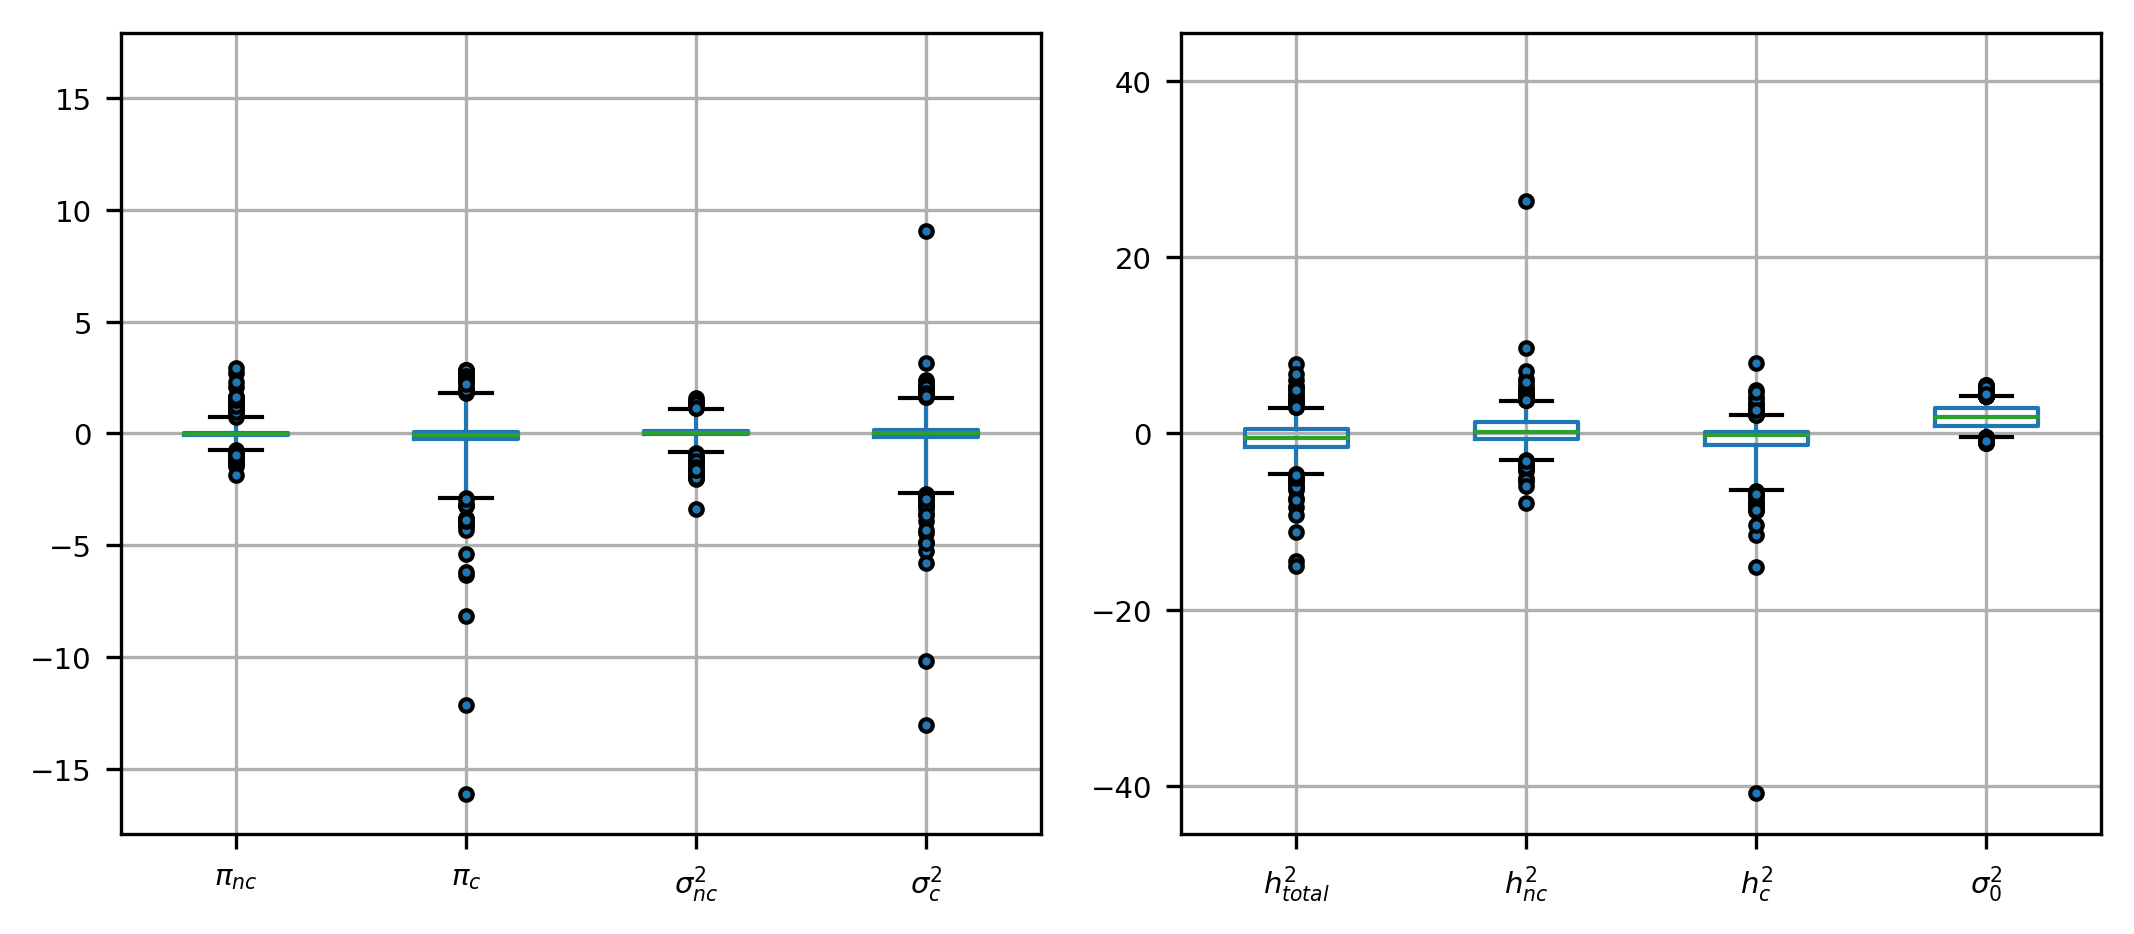

In [21]:
# bar chart for the main text
table_dir = "/mnt/seagate10/projects/cmm/experiments/e1/tables"
# table_dir = "/mnt/c/Users/Алексей/Downloads/cmm_e1"
fig_out_dir = "/mnt/seagate10/projects/cmm/experiments/e1/figures"
# fig_out_dir = "/mnt/c/Users/Алексей/Downloads/cmm_e1/figures"
merged_table_f = os.path.join(table_dir, f"e1.merged.csv")
# merged_table_f = os.path.join("/mnt/c/Users/Алексей/Downloads/cmm_e1/e1.causals.merged.csv")
df = pd.read_csv(merged_table_f)


plt.rcParams["font.size"] = 7
# plt.rcParams["text.usetex"]=True

logscale_par = ["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]
logscale_par_tick_labels = ['$\pi_{nc}$', '$\pi_{c}$', '$\sigma^{2}_{nc}$', '$\sigma^{2}_{c}$']
linscale_par = ["qual_h2","qual_h2_nc","qual_h2_c","qual_s02"]
linscale_par_tick_labels = ['$h^{2}_{total}$', '$h^{2}_{nc}$', '$h^{2}_{c}$', '$\sigma^{2}_{0}$']


df["max_h2"] = df[["h2_nc","h2_c"]].max(axis=1)
df["min_h2"] = df[["h2_nc","h2_c"]].min(axis=1)
df["max_of_total"] = df.max_h2/df.h2
df["bad_qual"] = df[["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]].abs().max(axis=1)

# for each combination of "i_h2","i_p_c","i_p_nc","i_s2","i_repeat" take the run with the min cost function value
df = df.sort_values("cost").groupby(by=["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"],as_index=False).first()
# df = df.groupby(by=["i_h2","i_p_c","i_p_nc","i_s2"],as_index=False).first()
print(df.shape)
# df = df.loc[(df.p_c>1E-3) & (df.p_nc>1E-4) & (df.s2_c>1E-5) & (df.s2_nc>1E-6),:]

print(df.shape)

dpi = 300

flierprops = dict(marker='.', markerfacecolor='C0', markersize=6, linestyle='none')
whis = [2.5,97.5]

def set_simmetric_lim(ax):
    y_min, y_max = ax.get_ylim()
    y_lim = max(y_max, abs(y_min))
    y_lim = 1.03*y_lim
    ax.set_ylim((-y_lim,y_lim))

ncols=2
fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(7,3), constrained_layout=True,
                        gridspec_kw={'width_ratios':[len(logscale_par),len(linscale_par)]}, dpi=dpi)

df.loc[:,logscale_par].boxplot(ax=axs[0],whis=whis,flierprops=flierprops)
df.loc[:,linscale_par].boxplot(ax=axs[1],whis=whis,flierprops=flierprops)
set_simmetric_lim(axs[0])
set_simmetric_lim(axs[1])
axs[0].set_xticklabels(logscale_par_tick_labels)
axs[1].set_xticklabels(linscale_par_tick_labels)


plt.show()


In [5]:
ddf = df.loc[df.bad_qual>1]
ddf[ddf.columns[:12]].loc[:,["i_h2","i_p_c","i_p_nc","i_s2"]].describe()

,i_h2,i_p_c,i_p_nc,i_s2
count,252,252,252,252
unique,3,3,3,3
top,A,C,A,A
freq,112,119,131,130


In [17]:
df["bad_qual"] = df[["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]].abs().max(axis=1)
ddf = df.loc[df.bad_qual>0.5]
df_ind = ddf.loc[:,["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"]]
df_ind = df_ind.replace(to_replace={s:str(i) for i,s in enumerate("ABC")})
df_ind.to_csv("bad_qual_070519.csv",sep=" ",index=False,header=False)

In [62]:
ddf = df.loc[(df.qual_s2_c<-5) | (df.qual_p_c<-5),]
df_ind = ddf.loc[:,["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"]]
df_ind = df_ind.replace(to_replace={s:str(i) for i,s in enumerate("ABC")})
df_ind.to_csv("bad_qual_200519.csv",sep=" ",index=False,header=False)

In [78]:
ddf = df.loc[df.qual_h2.abs() > 5,]
df_ind = ddf.loc[:,["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"]]
df_ind = df_ind.replace(to_replace={s:str(i) for i,s in enumerate("ABC")})
df_ind.to_csv("bad_qual_200519_h2.csv",sep=" ",index=False,header=False)

In [26]:
df.n_c.unique()

array([16363,  1636,   163])

170 coding enriched h2_70 tests
170 coding enriched h2_40 tests
170 coding enriched h2_10 tests
60 balanced h2_70 tests
60 balanced h2_40 tests
60 balanced h2_10 tests
40 noncoding enriched h2_70 tests
40 noncoding enriched h2_40 tests
40 noncoding enriched h2_10 tests


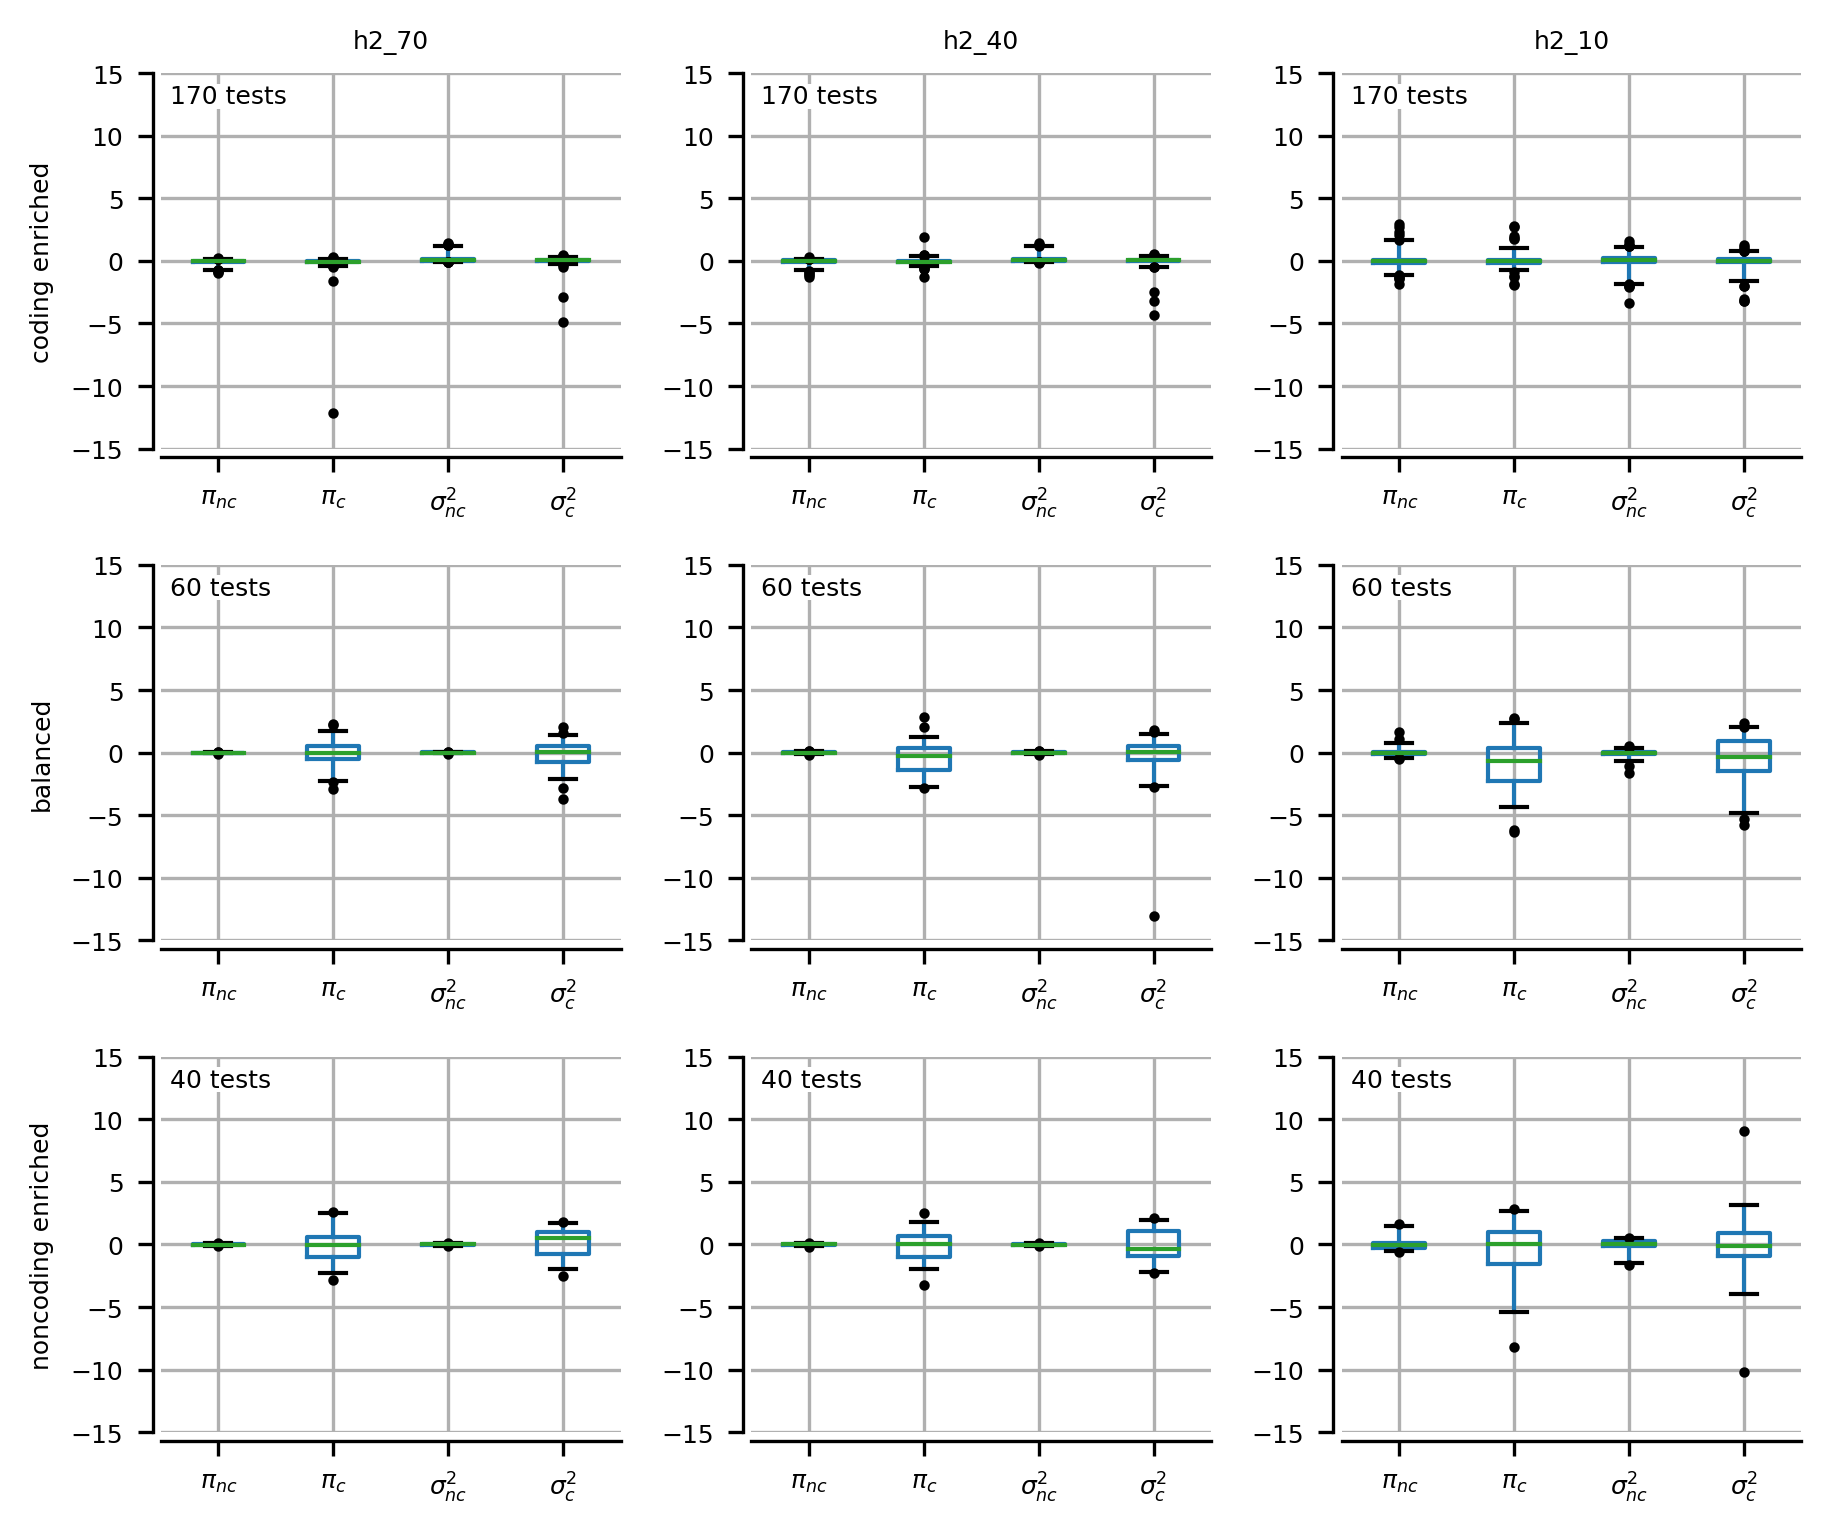

In [19]:
from collections import OrderedDict
ratio = n_coding/n_noncoding
factor = 5.
i_enriched_coding = (df.h2_c/df.h2_nc>=factor*ratio)
i_balanced = (ratio/factor<df.h2_c/df.h2_nc) & (df.h2_c/df.h2_nc <factor*ratio)
i_enriched_noncoding = (df.h2_c/df.h2_nc<=ratio/factor)
i_h2_70 = df.h2>0.6
i_h2_40 = (df.h2>0.3) & (df.h2<0.5)
i_h2_10 = df.h2<0.2
enrich_dict = OrderedDict({"coding enriched":i_enriched_coding,"balanced":i_balanced,"noncoding enriched":i_enriched_noncoding})
h2_dict = OrderedDict({"h2_70":i_h2_70,"h2_40":i_h2_40,"h2_10":i_h2_10})


def set_simmetric_lim(ax):
    y_min, y_max = ax.get_ylim()
    y_lim = max(y_max, abs(y_min))
    y_lim = 1.03*y_lim
    ax.set_ylim((-y_lim,y_lim))

font_size = 6
plt.rcParams["font.size"] = font_size
# plt.rcParams["text.usetex"]=True

logscale_par = ["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]
logscale_par_tick_labels = ['$\pi_{nc}$', '$\pi_{c}$', '$\sigma^{2}_{nc}$', '$\sigma^{2}_{c}$']
linscale_par = ["qual_h2","qual_h2_nc","qual_h2_c","qual_s02"]
linscale_par_tick_labels = ['$h^{2}_{total}$', '$h^{2}_{nc}$', '$h^{2}_{c}$', '$\sigma^{2}_{0}$']

dpi = 300
whis = [2.5,97.5]
flierprops = dict(marker='.', markeredgecolor='k',markerfacecolor='k', markersize=3,linestyle='none')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(6,5), constrained_layout=True, dpi=dpi)

row_i = 0
for enrich_key, enrich_ind in enrich_dict.items():
    col_i = 0
    for h2_key, h2_ind in h2_dict.items():
        ax = axs[row_i,col_i]
        i = enrich_ind & h2_ind
        print(f"{i.sum()} {enrich_key} {h2_key} tests")
        df.loc[i,logscale_par].boxplot(ax=ax,whis=whis,flierprops=flierprops)
        
        set_simmetric_lim(ax)
        ax.set_xticklabels(logscale_par_tick_labels)
        
        if row_i == 0:
            ax.set_title(f"{h2_key}",fontsize=font_size)
        if col_i == 0:
            ax.set_ylabel(f"{enrich_key}")
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_position(('outward',2))
        ax.spines['bottom'].set_position(('outward',2))
        
        ax.annotate(f"{i.sum()} tests",xy=(0.02,0.92),xycoords='axes fraction',fontweight="normal",ha="left",
                   bbox={"boxstyle":"square, pad=0.02", "facecolor":"white","edgecolor":"none","alpha":1})
        
        ax.set_ylim(-15,15)
        col_i += 1
    row_i += 1

plt.show()

In [11]:
df.loc[i_balanced & i_h2_40,:].loc[df.qual_p_c<-10,:]

,i_h2,i_p_c,i_p_nc,i_s2,i_repeat,run,p_nc,p_c,s2_nc,s2_c,...,qual_s2_nc,qual_s2_c,qual_h2,qual_h2_nc,qual_h2_c,qual_s02,max_h2,min_h2,max_of_total,bad_qual
374,B,B,A,B,5,2,0.01,0.009998,0.000017,0.000017,...,-0.003994,0.797267,-0.542499,-0.000561,-0.541938,1.428377,0.398492,0.005419,0.986583,16.147567


90 #noncoding = 108521 #coding = 16363 tests


TypeError: zip argument #2 must support iteration

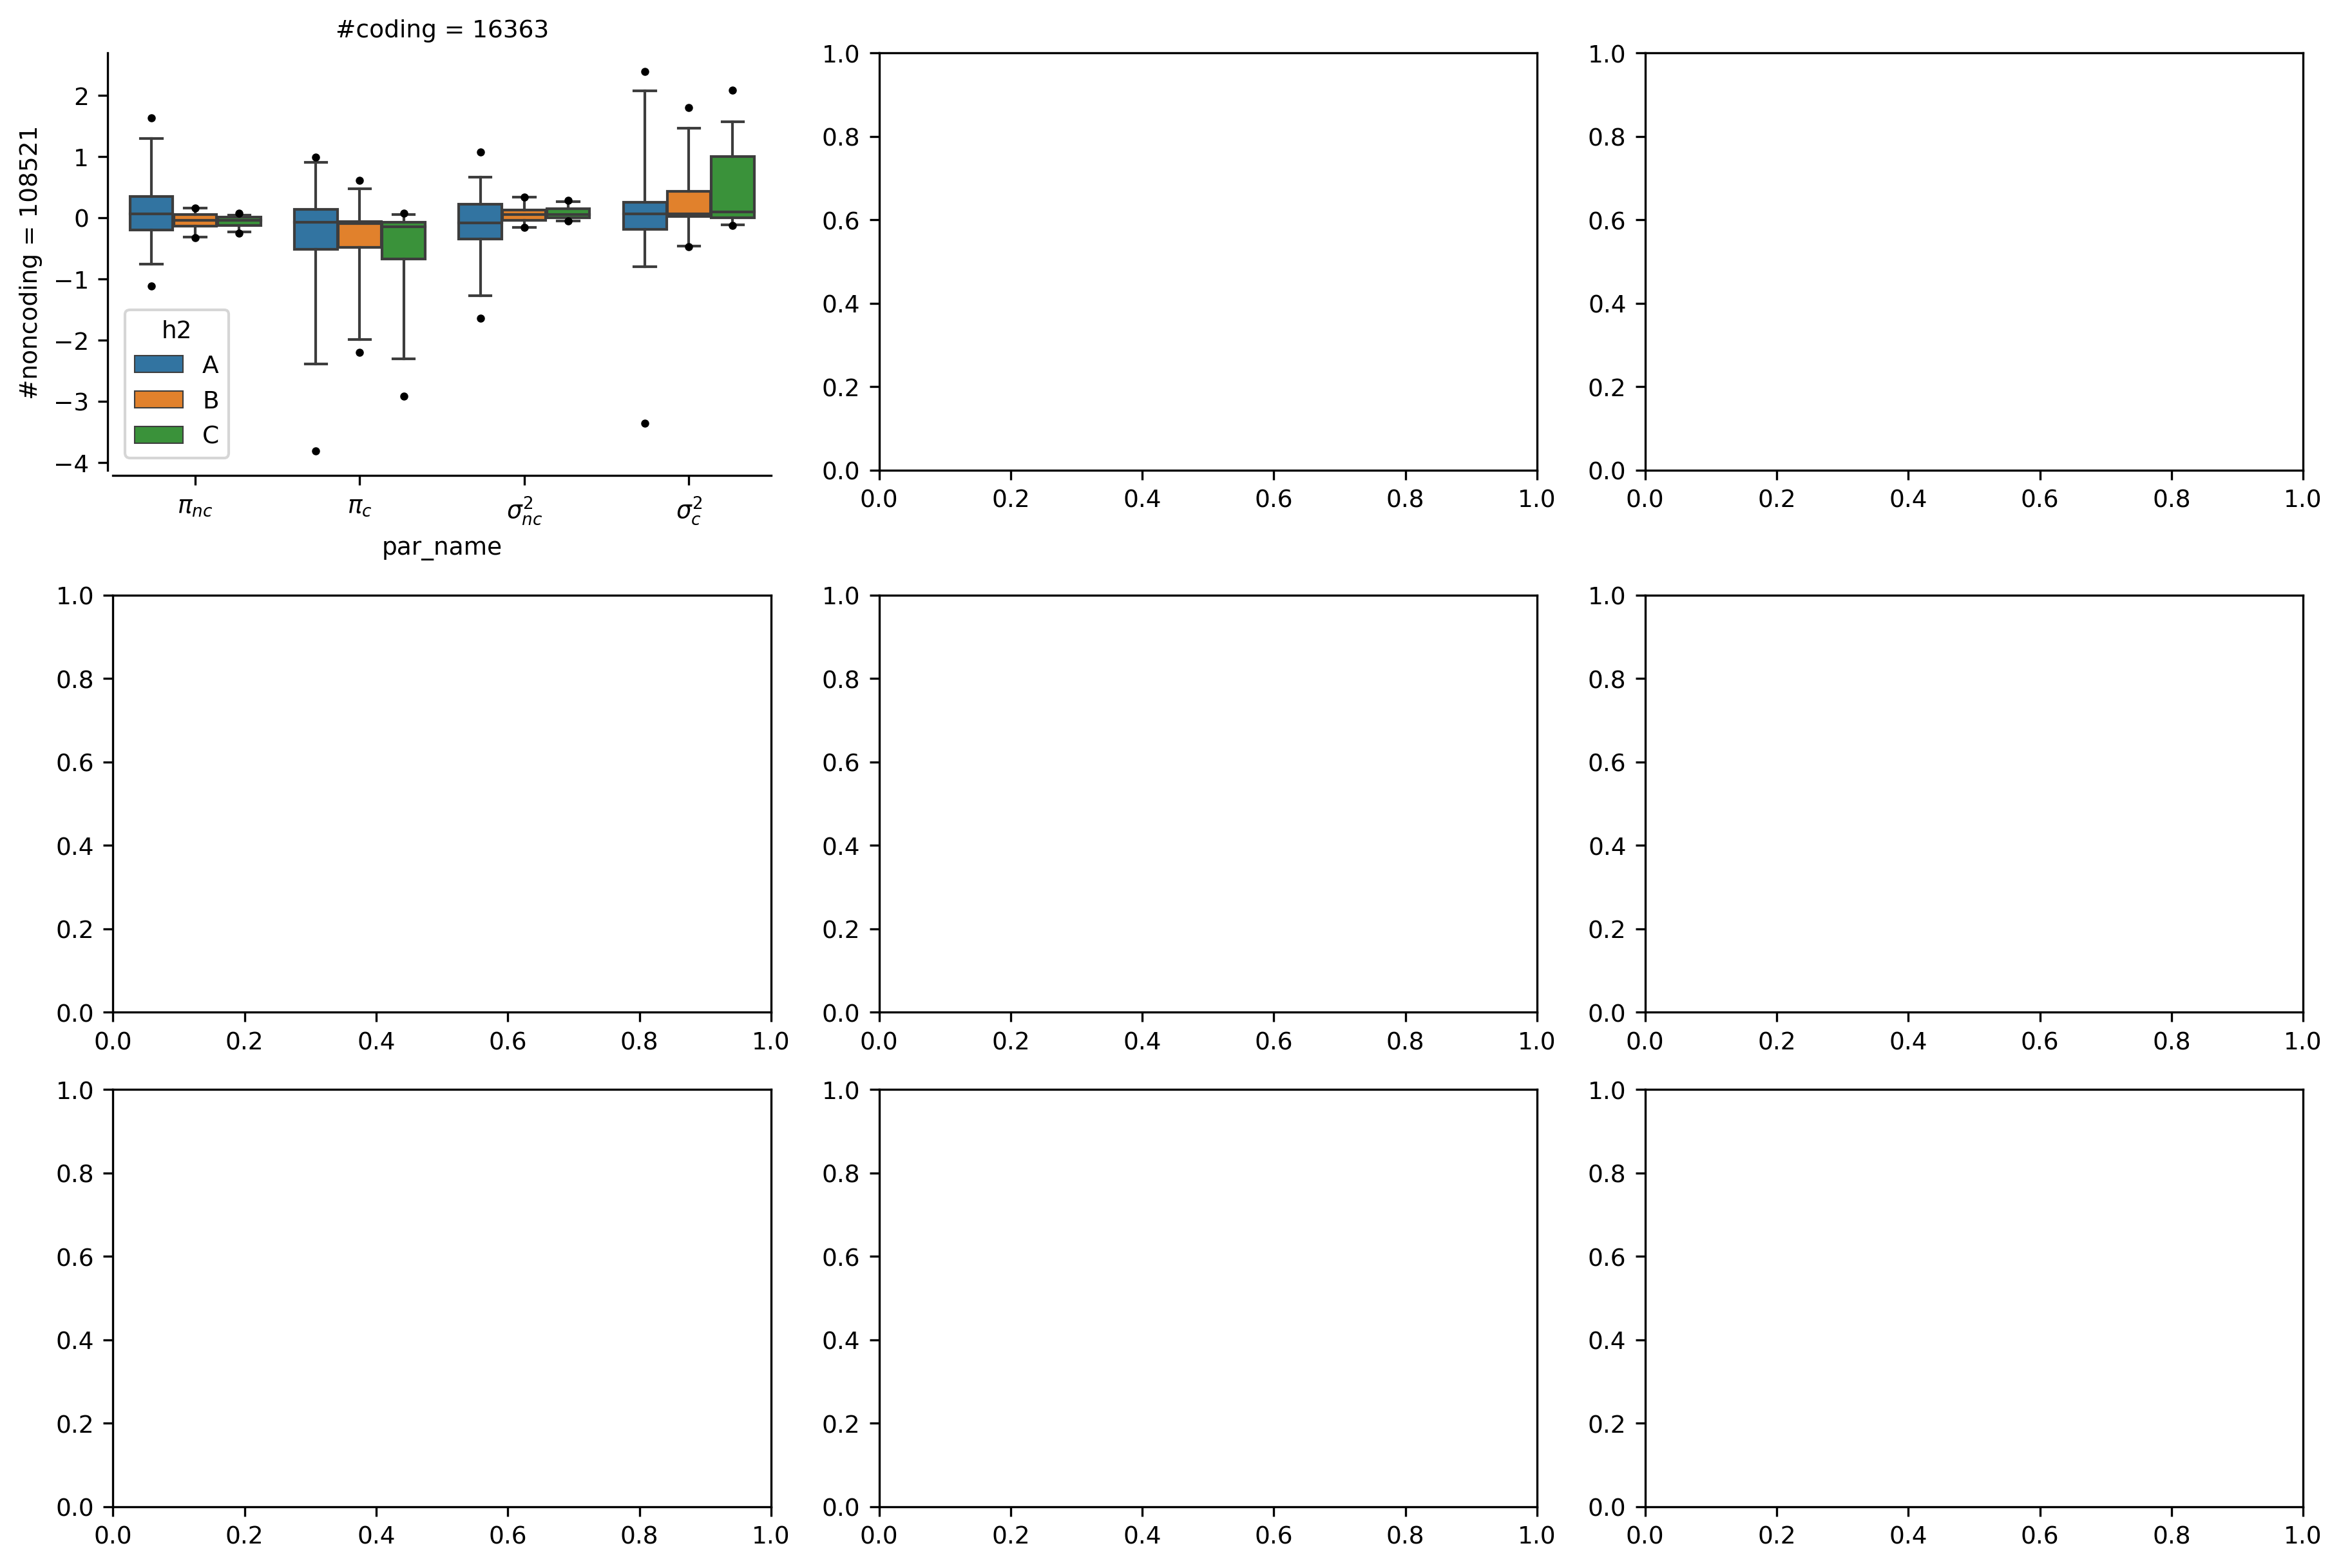

In [56]:
from collections import OrderedDict
import seaborn as sns

n_nc = [108521,  10852,   1085]
n_c = [16363,  1636,   163]

i1_dict = OrderedDict()
for n in n_nc:
    i = (df.n_nc == n)
    i1_dict[f"#noncoding = {n}"] = i

i2_dict = OrderedDict()
for n in n_c:
    i = (df.n_c == n)
    i2_dict[f"#coding = {n}"] = i


def set_simmetric_lim(ax):
    y_min, y_max = ax.get_ylim()
    y_lim = max(y_max, abs(y_min))
    y_lim = 1.03*y_lim
    ax.set_ylim((-y_lim,y_lim))

font_size = 9
plt.rcParams["font.size"] = font_size
# plt.rcParams["text.usetex"]=True

logscale_par = ["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]
logscale_par_tick_labels = ['$\pi_{nc}$', '$\pi_{c}$', '$\sigma^{2}_{nc}$', '$\sigma^{2}_{c}$']
linscale_par = ["qual_h2","qual_h2_nc","qual_h2_c","qual_s02"]
linscale_par_tick_labels = ['$h^{2}_{total}$', '$h^{2}_{nc}$', '$h^{2}_{c}$', '$\sigma^{2}_{0}$']

hue_par = "i_h2"
hue_par_col = "h2"
deviation_par_col = "deviation"

dpi = 300
whis = [2.5,97.5]
flierprops = dict(marker='.', markeredgecolor='k',markerfacecolor='k', markersize=4,linestyle='none')
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,8), constrained_layout=True, dpi=dpi)

row_i = 0
for i1_key, i1_ind in i1_dict.items():
    col_i = 0
    for i2_key, i2_ind in i2_dict.items():
        ax = axs[row_i,col_i]
        i = i1_ind & i2_ind
        print(f"{i.sum()} {i1_key} {i2_key} tests")
        
        current_df = df.loc[i,[hue_par]+logscale_par]
        n_rows = i.sum()
        columns2plot = [hue_par_col,deviation_par_col]
        df2plot = pd.DataFrame(columns=columns2plot)
        par_name = []
        for par in logscale_par:
            par_df = current_df.loc[:,[hue_par,par]]
            par_df.columns = columns2plot
            df2plot = df2plot.append(par_df)
            par_name += [par]*n_rows
        df2plot["par_name"] = par_name
        
#         kwargs = {"whis":whis,"flierprops":flierprops}
        sns.boxplot(x="par_name",y=deviation_par_col,hue=hue_par_col,linewidth=1,
            data=df2plot,ax=ax,whis=whis,flierprops=flierprops) # palette=["m", "g"],
        
#         df.loc[i,logscale_par].boxplot(ax=ax,whis=whis,flierprops=flierprops)
        
#         set_simmetric_lim(ax)
        ax.set_xticklabels(logscale_par_tick_labels)
        
        if row_i == 0:
            ax.set_title(f"{i2_key}",fontsize=font_size)
        if col_i == 0:
            ax.set_ylabel(f"{i1_key}")
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_position(('outward',2))
        ax.spines['bottom'].set_position(('outward',2))
        
        ax.legend(None)
        
#         ax.annotate(f"{i.sum()} tests",xy=(0.02,0.92),xycoords='axes fraction',fontweight="normal",ha="left",
#                    bbox={"boxstyle":"square, pad=0.02", "facecolor":"white","edgecolor":"none","alpha":1})
        
#         ax.set_ylim(-2,2)
        col_i += 1
    row_i += 1

plt.show()

(810, 45)


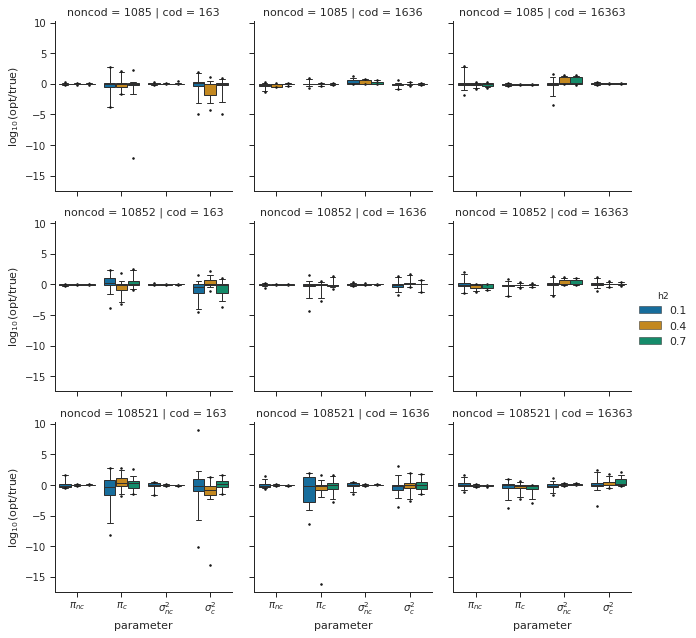

In [4]:
import seaborn as sns
sns.set(font_scale=1.15,style="ticks",context="paper")

table_dir = "/mnt/seagate10/projects/cmm/experiments/e1/tables"
merged_table_f = os.path.join(table_dir, f"e1.merged.csv")
outf="e1.boxplot.png"

df = pd.read_csv(merged_table_f)


logscale_par = ["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]
logscale_par_tick_labels = ['$\pi_{nc}$', '$\pi_{c}$', '$\sigma^{2}_{nc}$', '$\sigma^{2}_{c}$']
qual_col= 'log$_{10}$(opt/true)'

# linscale_par = ["qual_h2","qual_h2_nc","qual_h2_c","qual_s02"]
# linscale_par_tick_labels = ['$h^{2}_{total}$', '$h^{2}_{nc}$', '$h^{2}_{c}$', '$\sigma^{2}_{0}$']


df["max_h2"] = df[["h2_nc","h2_c"]].max(axis=1)
df["min_h2"] = df[["h2_nc","h2_c"]].min(axis=1)
df["max_of_total"] = df.max_h2/df.h2
df["bad_qual"] = df[["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]].abs().max(axis=1)

# for each combination of "i_h2","i_p_c","i_p_nc","i_s2","i_repeat" take the run with the min cost function value
df = df.sort_values("cost").groupby(by=["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"],as_index=False).first()
# df = df.groupby(by=["i_h2","i_p_c","i_p_nc","i_s2"],as_index=False).first()
print(df.shape)

whis = [2.5,97.5]
flierprops = dict(marker='.', markeredgecolor='k',markerfacecolor='k', markersize=3,linestyle='none')

n_rows = df.shape[0]
col2use = ["i_h2","n_nc","n_c"]
col2plot = col2use + [qual_col]
df2plot = pd.DataFrame(columns=col2plot)
par_name = []
for i,par in enumerate(logscale_par):
    par_df = df.loc[:,col2use+[par]]
    par_df.columns = col2plot
    df2plot = df2plot.append(par_df)
    par_name += [logscale_par_tick_labels[i]]*n_rows
df2plot["parameter"] = par_name

col_rename_dict = {"n_nc":"noncod","n_c":"cod"}
cols = [col_rename_dict.get(c,c) for c in df2plot.columns]
df2plot.columns = cols

h2_dict={"A":"0.1","B":"0.4","C":"0.7"}
h2_col = [h2_dict[h2] for h2 in df2plot.i_h2]
df2plot["h2"] = h2_col

g = sns.FacetGrid(df2plot,col="cod",row="noncod") # ,ylim=(-5,5)
g = (g.map(sns.boxplot,"parameter",qual_col,"h2",order=logscale_par_tick_labels,hue_order=["0.1","0.4","0.7"],
           palette="colorblind",linewidth=1,whis=whis,flierprops=flierprops).add_legend(title="h2",fontsize=11))

plt.savefig(outf,dpi=500)

In [62]:
df2plot.head()

,i_h2,n_nc,n_c,qual,par_name
0,A,108521,16363,0.051682,qual_p_nc
1,A,108521,16363,-0.444666,qual_p_nc
2,A,108521,16363,0.135529,qual_p_nc
3,A,108521,16363,-0.400064,qual_p_nc
4,A,108521,16363,0.077468,qual_p_nc


(810, 45)


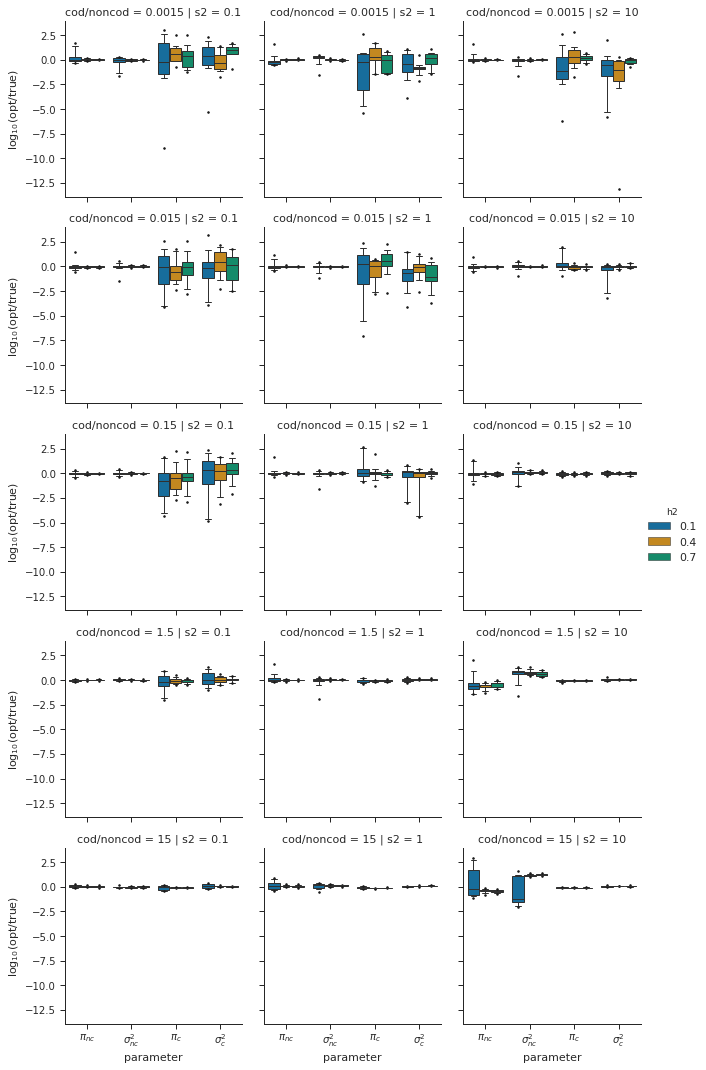

In [4]:
import seaborn as sns
sns.set(font_scale=1.15,style="ticks",context="paper")

table_dir = "/mnt/seagate10/projects/cmm/experiments/e1/tables"
merged_table_f = os.path.join(table_dir, f"e1.merged.10runs.csv")
outf="e1.boxplot.15tiles.png"

df = pd.read_csv(merged_table_f)

logscale_par = ["qual_p_nc","qual_s2_nc","qual_p_c","qual_s2_c"]
logscale_par_tick_labels = ['$\pi_{nc}$','$\sigma^{2}_{nc}$','$\pi_{c}$','$\sigma^{2}_{c}$']
qual_col= 'log$_{10}$(opt/true)'

df["max_h2"] = df[["h2_nc","h2_c"]].max(axis=1)
df["min_h2"] = df[["h2_nc","h2_c"]].min(axis=1)
df["max_of_total"] = df.max_h2/df.h2
df["bad_qual"] = df[["qual_p_nc","qual_p_c","qual_s2_nc","qual_s2_c"]].abs().max(axis=1)

#for each combination of "i_h2","i_p_c","i_p_nc","i_s2","i_repeat" take the run with the min cost function value
df = df.sort_values("cost").groupby(by=["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"],as_index=False).first()
# df = df.groupby(by=["i_h2","i_p_c","i_p_nc","i_s2"],as_index=False).first()

print(df.shape)

whis = [2.5,97.5]
flierprops = dict(marker='.',markeredgecolor='k',markerfacecolor='k',markersize=3,linestyle='none')

n_rows = df.shape[0]
col2use = ["i_h2","i_p_c","i_p_nc","n_nc","n_c","i_s2"]
col2plot = col2use + [qual_col]
df2plot = pd.DataFrame(columns=col2plot)
par_name = []
for i,par in enumerate(logscale_par):
    par_df = df.loc[:,col2use+[par]]
    par_df.columns = col2plot
    df2plot = df2plot.append(par_df)
    par_name += [logscale_par_tick_labels[i]]*n_rows
df2plot["parameter"] = par_name

s2_dict={"A":"0.1","B":"1","C":"10"}
s2_col = [s2_dict[s2] for s2 in df2plot.i_s2]
df2plot["s2"] = s2_col

def get_c_nc_col(c,nc):
    if c == nc: return "0.15"
    elif (c == "B" and nc == "C") or (c == "A" and nc == "B"): return "1.5"
    elif (c == "A" and nc == "C"): return "15"
    elif (nc == "B" and c == "C") or (nc == "A" and c == "B"): return "0.015"
    elif (nc == "A" and c == "C"): return "0.0015"

c_nc_col = [get_c_nc_col(c,nc) for c,nc in zip(df2plot.i_p_c,df2plot.i_p_nc)]
df2plot["cod/noncod"] = c_nc_col

h2_dict={"A":"0.1","B":"0.4","C":"0.7"}
h2_col = [h2_dict[h2] for h2 in df2plot.i_h2]
df2plot["h2"] = h2_col

g = sns.FacetGrid(df2plot,col="s2",row="cod/noncod") # ,ylim=(-5,5)
g = (g.map(sns.boxplot,"parameter",qual_col,"h2",order=logscale_par_tick_labels,hue_order=["0.1","0.4","0.7"],
           palette="colorblind",linewidth=1,whis=whis,flierprops=flierprops).add_legend(title="h2",fontsize=11))

plt.savefig(outf,dpi=500)

In [5]:
df[df.bad_qual>7]

,i_h2,i_p_c,i_p_nc,i_s2,i_repeat,run,p_nc,p_c,s2_nc,s2_c,...,qual_s2_nc,qual_s2_c,qual_h2,qual_h2_nc,qual_h2_c,qual_s02,max_h2,min_h2,max_of_total,bad_qual
107,A,B,A,B,8,8,0.01,0.009998,0.000004,4.211764e-06,...,-1.175493,-0.039910,-0.808134,-0.673820,-0.134314,1.453326,0.098522,0.001343,0.986550,7.034774
180,A,C,A,A,1,8,0.01,0.000996,0.000004,3.921774e-07,...,-1.616421,-5.261524,0.906903,0.908447,-0.001544,-0.270913,0.100746,0.000015,0.999847,8.966433
477,B,C,A,C,8,8,0.01,0.000996,0.000017,1.447245e-04,...,-0.007032,-13.084576,0.774605,1.225047,-0.450442,1.007396,0.395175,0.004504,0.988730,13.084576


In [28]:
prop_h2_c_nc = df.h2_c/df.h2_nc
prop_h2_nc_c = df.h2_nc/df.h2_c
min_porp_h2 = [min(hc2/h2,hnc2/h2) for hc2,hnc2,h2 in zip(df.h2_c,df.h2_nc,df.h2) if min(hc2/h2,hnc2/h2)<0.2]

(array([319.,  11.,   0.,  14.,  78.,   8.,  43., 136.,  14.,   7.]),
 array([9.53865106e-05, 1.63135363e-02, 3.25316861e-02, 4.87498358e-02,
        6.49679856e-02, 8.11861354e-02, 9.74042851e-02, 1.13622435e-01,
        1.29840585e-01, 1.46058734e-01, 1.62276884e-01]),
 <a list of 10 Patch objects>)

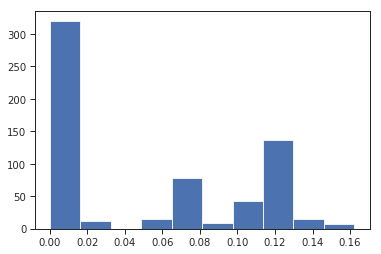

In [29]:
plt.hist(min_porp_h2)

In [33]:
print(f"{(df.h2_nc/df.h2 < 0.02).sum()} nc < 0.02")
print(f"{((df.h2_nc/df.h2 > 0.02) & (df.h2_nc/df.h2 < 0.2)).sum()} 0.02 < nc < 0.2")
print(f"{(df.h2_nc/df.h2 > 0.2).sum()} 0.2 < nc")
print("")
print(f"{(df.h2_c/df.h2 < 0.02).sum()} c < 0.02")
print(f"{((df.h2_c/df.h2 > 0.02) & (df.h2_c/df.h2 < 0.2)).sum()} 0.02 < c < 0.2")
print(f"{(df.h2_c/df.h2 > 0.2).sum()} 0.2 < c")

30 nc < 0.02
90 0.02 < nc < 0.2
690 0.2 < nc

300 c < 0.02
210 0.02 < c < 0.2
300 0.2 < c


(810, 41)


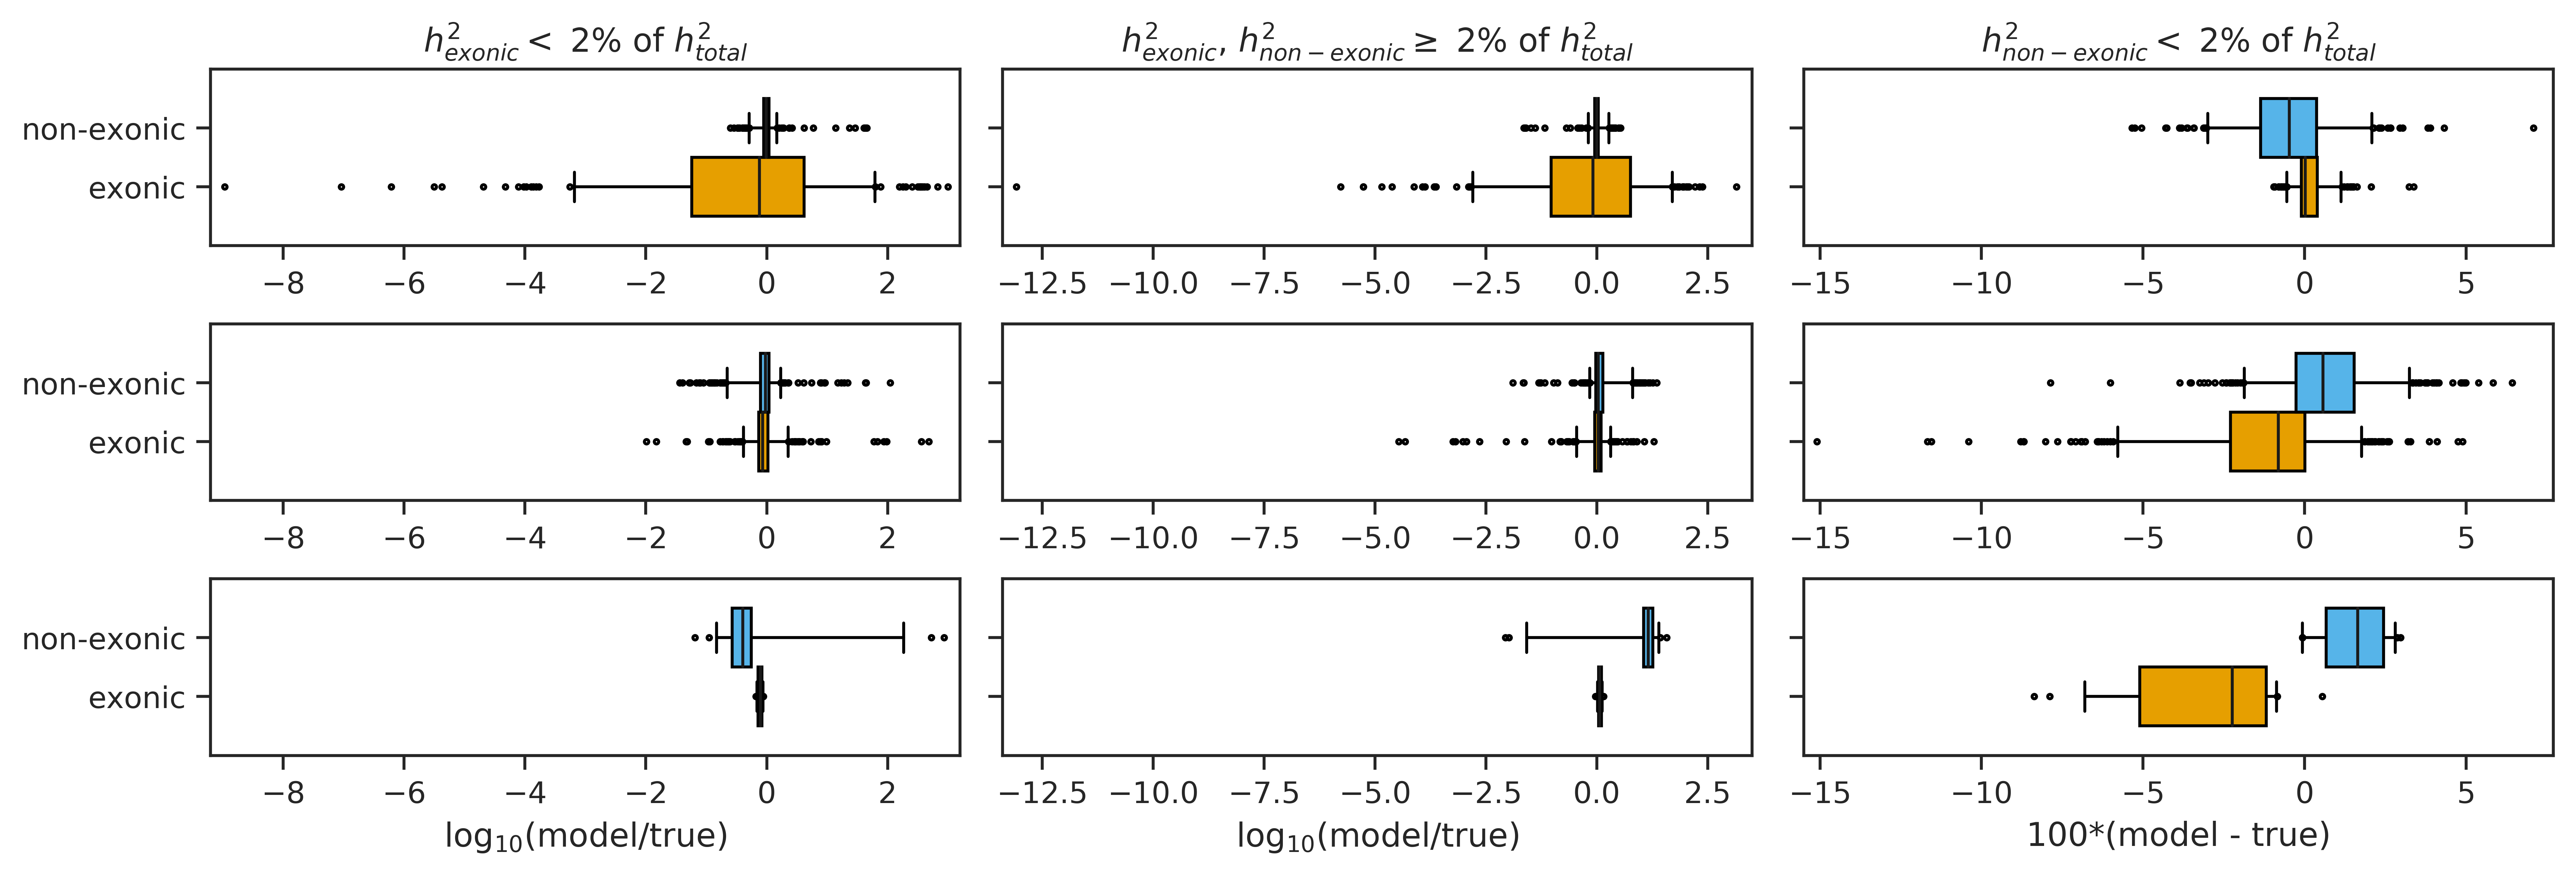

In [89]:
# Supplementary Figure 1
# import seaborn as sns
# sns.set(font_scale=1.15,style="ticks",context="paper")

table_dir = "/mnt/c/Users/Алексей/Documents/MEGAsync/cmm_paper/data/e1/"
merged_table_f = os.path.join(table_dir, f"e1.merged.15runs.csv")
outf="supplementary_figure_1.svg"

color_coding = "#e69f00"
color_noncoding = "#56b4e9"

df = pd.read_csv(merged_table_f)
df = df.sort_values("cost").groupby(by=["i_h2","i_p_c","i_p_nc","i_s2","i_repeat"],as_index=False).first()


print(df.shape)

i_h2_e_small = (df.h2_c < 0.02*df.h2)
i_h2_ne_small = (df.h2_nc < 0.02*df.h2)
i_good = ~ (i_h2_e_small | i_h2_ne_small)

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(12,4), sharex=False, sharey=True, constrained_layout=True, dpi=600)
boxes = []
columns = ["p", "s2", "h2"]
rows = [i_h2_e_small,i_good,i_h2_ne_small]

for i,r in enumerate(rows):
    for j,c in enumerate(columns):
        df_current = df.loc[r,:]
        exonic_col = f"qual_{c}_c"
        nonexonic_col = f"qual_{c}_nc"
        data = [df_current[exonic_col], df_current[nonexonic_col]]
        bp = axs[i][j].boxplot(data,vert=False,sym='.',positions=[0.25,0.75],widths=0.5,whis=[5,95],
                               labels=["exonic","non-exonic"],patch_artist=True)
        boxes.append(bp)
        

axs[0,0].set_title(r"Polygenicity ($\pi$)")
axs[0,1].set_title(r"Variance of effect size distribution ($\sigma^{2}$)")
axs[0,2].set_title(r"Heritability ($h^2$)")

# axs[0,0].set_title(r"$h^{2}_{exonic} <$ 2% of $h^{2}_{total}$")
# axs[0,1].set_title(r"$h^{2}_{exonic}$, $h^{2}_{non-exonic} \geq$ 2% of $h^{2}_{total}$")
# axs[0,2].set_title(r"$h^{2}_{non-exonic} <$ 2% of $h^{2}_{total}$")

axs[2,0].set_xlabel(r"log$_{10}$(model/true)")
axs[2,1].set_xlabel(r"log$_{10}$(model/true)")
axs[2,2].set_xlabel(r"100*(model - true)")

for i in range(3):
    axs[i][0].set_xlim((-9.2,3.2))
    axs[i][1].set_xlim((-13.4,3.5))
    axs[i][2].set_xlim((-15.5,7.7))

for b in boxes:
    b["boxes"][0].set_facecolor(color_coding)
    b["boxes"][1].set_facecolor(color_noncoding)
    for i in (0,1):
        b['fliers'][i].set(marker='.',ms=3)
    for i in (0,1):
        b['medians'][i].set(color='k')

if not outf is None:
    plt.savefig(outf)

In [13]:
i_h2_e_small = (df.h2_c < 0.02*df.h2_nc)
i_h2_ne_small = (df.h2_nc < 0.02*df.h2_c)
i_good = ~ (i_h2_e_small | i_h2_ne_small)

In [14]:
i_h2_e_small.sum(), i_h2_ne_small.sum(), i_good.sum()

(300, 30, 480)

In [19]:
df.columns

Index(['i_h2', 'i_p_c', 'i_p_nc', 'i_s2', 'i_repeat', 'run', 'p_nc', 'p_c',
       's2_nc', 's2_c', 'h2', 'h2_nc', 'h2_c', 's02', 'n_nc', 'n_c',
       'sim_p_nc', 'sim_p_c', 'sim_s2_nc', 'sim_s2_c', 'sim_h2', 'sim_h2_nc',
       'sim_h2_c', 'sim_s02', 'sim_n_nc', 'sim_n_c', 'success', 'cost',
       'total_nfev', 'loc_nfev', 'loc_nit', 'glob_nfev', 'glob_cost',
       'qual_p_nc', 'qual_p_c', 'qual_s2_nc', 'qual_s2_c', 'qual_h2',
       'qual_h2_nc', 'qual_h2_c', 'qual_s02'],
      dtype='object')

In [34]:
bp00

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8ae45ad5f8>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8ae464e4a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8ae466ea90>,
 'medians': [<matplotlib.lines.Line2D at 0x7f8ae464ea58>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f8ae464efd0>,
 'means': []}